In [1]:
import pandas as pd
from math import pi, sin, cos, exp, tan, acos, isclose

 
import numpy as np
import re
from itertools import groupby
from os import listdir, path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar
from prov.model import ProvDocument
import datetime
from prov.dot import prov_to_dot
from IPython.display import Image


In [2]:
pi = 3.1412

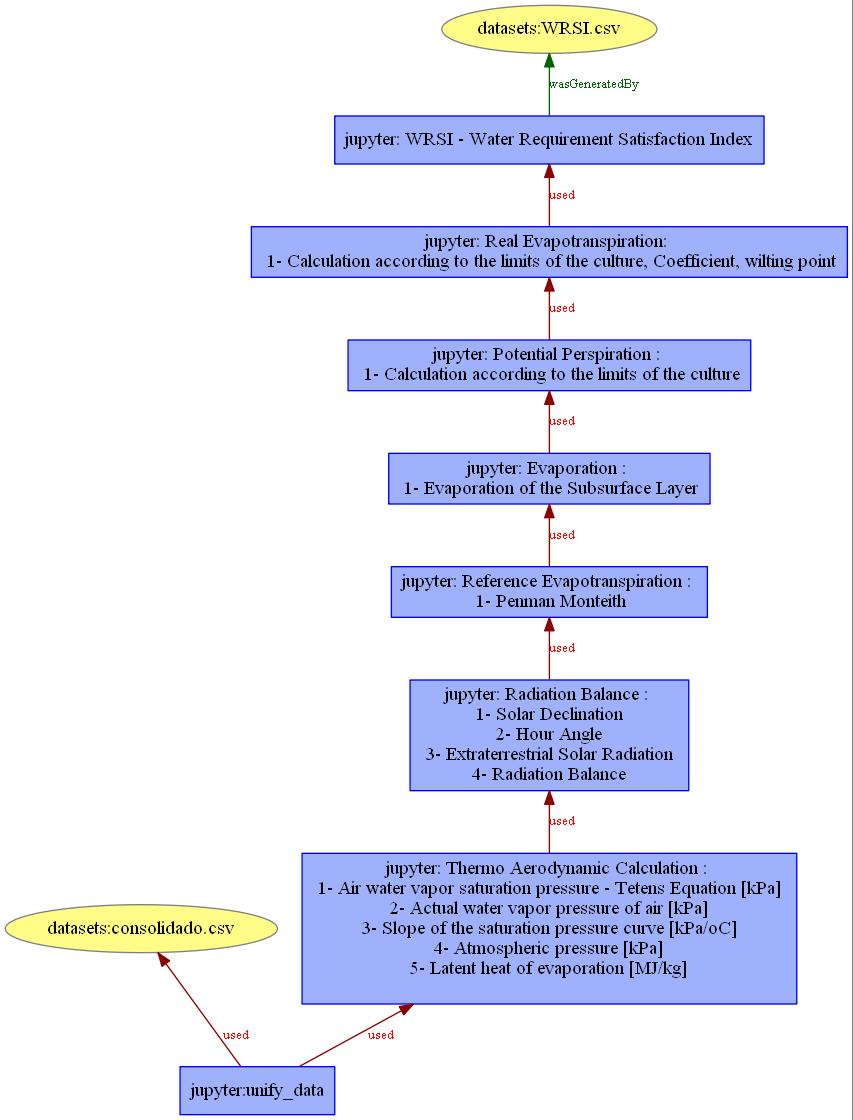

In [35]:
d1 = ProvDocument()

# Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
d1.add_namespace('inmet', 'datasets/consolidados.csv')
d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
d1.add_namespace('datasets', 'datasets/')
d1.add_namespace('jupyter', 'KcDual-py.ipynb')
d1.add_namespace('local', 'zip')

# Adding an Agent 
#agent = 'foaf:AlexSantoss'
#d1.agent(agent)

# Adding an entity
entity = 'datasets:consolidado.csv'
e1 = d1.entity(entity)
 
entity = 'datasets:WRSI.csv'
e2 = d1.entity(entity)

#Generation
#a1 = 'local:conslidados'
#d1.activity(a1)

a2 = 'jupyter:unify_data'
d1.activity(a2)

a3 = 'jupyter: Thermo Aerodynamic Calculation : \n 1- Air water vapor saturation pressure - Tetens Equation [kPa] \n 2- Actual water vapor pressure of air [kPa] \n 3- Slope of the saturation pressure curve [kPa/oC] \n 4- Atmospheric pressure [kPa] \n 5- Latent heat of evaporation [MJ/kg] \n '
d1.activity(a3)

a4 = 'jupyter: Radiation Balance : \n 1- Solar Declination \n 2- Hour Angle \n 3- Extraterrestrial Solar Radiation \n 4- Radiation Balance \n'
d1.activity(a4)


a5 = 'jupyter: Reference Evapotranspiration : \n 1- Penman Monteith'
d1.activity(a5)

#a6 = 'jupyter: Potential Perspiration : \n 1- Calculation according to the limits of the culture  '
#d1.activity(a6)

a7 = 'jupyter: Evaporation : \n 1- Evaporation of the Subsurface Layer'
d1.activity(a7)

a8 = 'jupyter: Potential Perspiration : \n 1- Calculation according to the limits of the culture'
d1.activity(a8)

a9 = 'jupyter: Real Evapotranspiration: \n 1- Calculation according to the limits of the culture, Coefficient, wilting point'
d1.activity(a9)

a10 = 'jupyter: WRSI - Water Requirement Satisfaction Index'
d1.activity(a10)

#Relations
#d1.used(a1, e1)
#d1.wasGeneratedBy(e1, a1)
d1.used(a2, e1)
d1.used(a2, a3) #Termo_Aerodinâmico
d1.used(a3, a4) #Saldo_de_Radiação
d1.used(a4, a5) #Evapotranspiração_de_referência
#d1.used(a5, a6) #Transpiracao_Potencial
d1.used(a5, a7) #Evaporação
d1.used(a7, a8) #Transpiracao_Potencial
d1.used(a8, a9) #Evapotranspiração_Real
d1.used(a9, a10) #ISNA

d1.wasGeneratedBy(a10, e2)

dot = prov_to_dot(d1)
graph = "dot.jpeg"
dot.write_jpeg(graph)
Image(graph)

# Dicinoário de Dados
COEFICIENTE_BASAL    => KCB\
COEFICIENTE_CULTURA  => KC\
COEFICIENTE_EVAPO    => KE\
EVAPO_CULTURA        => ETC\
TRANSP_POTENCIAL     => TRP\
EVAPO                => E\
ARMAZENAMENTO_AGUA   => ARM\
Capacidade de Campo  => TAR\
ARM2                 => ARM2\
EVAPO_REFERENCIA     => ET0\
EVAPO_REAL           => ETR\
TR                   => TR\
TA                   => TA\
DIAJULIANO           => DIAJULIANO\
TARMEDIO             => TAR/2 \
Indice de Satisfação => ISNA\
PLUVIOSIDADE         => P\


In [4]:
#Termo Aerodinâmico    
def termoAeroDinamico(params, urx, urn, tx, tn):
    tm   = (tx + tn)/2
    #Pressão de saturação do vapor d'água do ar - Equação de Tetens [kPa]
    es   = (0.6108* exp(17.27*tx/(237.3+tx))+ 0.6108* exp(17.27*tn/(237.3+tn)))/2
    #Pressão real do vapor d'água do ar [kPa]   
    ea   = (urn * 0.6108* exp(17.27*tx/(237.3+tx))+ urx * 0.6108* exp(17.27*tn/(237.3+tn)))/ 200
    #Declividade da curva de pressão de saturação [kPa/oC]
    S    = 4098 * 0.6108* exp(17.27*tm/(237.3+tm))/((237.3 + tm)**2)
    #Pressão atmosférica [kPa]
    Patm = 101.3*((293-0.0065*params.Z)/(293))**5.26
    #Calor latente de evaporação [MJ/kg]
    lamb = 0.665E-3*Patm
    
    return S, tm, es, ea, lamb

#Termo Radioativo
def saldoDeRadiacao(params, doy, qg, tx, tn, ea):
    #Radiação solar extraterrestre

    #Correção relativa Terra-Sol
    dr   = 1 + 0.033 * cos(2*pi/365*doy)
    #Declinação Solar 
    decl = 0.409 * sin((2*pi/365*doy)-1.39)
    #Angulo Horário
    ws   = acos(-tan(params.FI*pi/180)*tan(decl))
    #Radiação Solar Extraterrestre
    Qo   = 37.568*dr*((ws*sin(params.FI*pi/180)*sin(decl))+(cos(params.FI*pi/180)*cos(decl)*sin(ws)))

    #Balanço de radiação
    #Ondas curtas
    
    #Radiação solar para dia de céu sem nebulosidade
    Qso = (0.75 + 2E-5*params.Z)*Qo
    Qoc = 0.77 * qg
    
    #Ondas longas
    Qol    = 4.903E-9*((((tx + 273.16)**4)+ ((tn + 273.16)**4))/2)*(0.34-0.14*ea**0.5)*(1.35*(qg/Qso)-0.35)

    return Qoc - Qol

#Transpiração Potencial
def transpiracaoPotencial(params, u2, urn, aETo_PM, t):
    if t < params.L_INI:
        Kcb = params.KCB_INI
    elif t < params.L_INI + params.L_CRES:
        Kcb = params.KCB_INI+(t-params.L_INI)/params.L_CRES*(params.KCB_MID-params.KCB_INI)
    elif t < params.L_INI + params.L_CRES + params.L_MID:
        Kcb = params.KCB_MID
    else:
        Kcb = params.KCB_MID+(t-(params.L_INI+params.L_CRES+params.L_MID))/(params.L_FIM*(params.KCB_FIM-params.KCB_MID))
        
    trp = Kcb * aETo_PM
    h = max((Kcb/params.KCB_MID)*params.HX,params.H)
    kcx = max(1.2+(0.04*(u2-2)-0.004*(urn-45))*(h/3)**0.3,Kcb+0.05)

    return Kcb, trp, h, kcx

#Balanço de água no solo
def evaporacao(params, p, Kcb, kcx, ETo_PM, De_f, h, t):
    #Camada subsuperfícial - Evaporação
    fc = max(abs(((Kcb-params.KCB_INI)/(kcx-params.KCB_INI)))**(1 + 0.5*params.H),0.01)
    
    if p > 0: fw = 1
    else: fw = params.FW_INI
    
    few = min(1-fc,fw)
    TAE = 1000*(params.CC-0.5*params.PM)*params.ZE
    
    if t == 1: De_i = TAE - params.AFE
    else: De_i = max(De_f-p, 0)
        
    if De_i < params.AFE: kr = 1
    else: kr = max((TAE - De_i)/(TAE - params.AFE), 0)
            
    ke = min(kr*(kcx-Kcb), few*kcx)
    E = ke * ETo_PM
    
    if t == 1:
        Dp = max(p, 0)
        De_f = min(De_i - p+(E/few) + Dp, TAE)
    else:
        Dp = max(p-De_f, 0)
        De_f = min(De_f - p+(E/few) + Dp, TAE)
        
    Kc = Kcb + ke
    ETc = Kc * ETo_PM

    return ETc, ke, De_f, De_i


def evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f, t):
    if t <= (params.L_INI + params.L_CRES + params.L_MID):
        Zr = ((aKcb - params.KCB_INI)/(params.KCB_MID - params.KCB_INI))*(params.ZRX - params.ZRN) + params.ZRN
    else:
        Zr = params.ZRN
    
    TAR = 1000.*(params.CC - params.PM)*Zr
    AFR = params.F*TAR
    
    if t == 1:
        Dr_i = min( max((TAR-AFR)-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)

        Dp = max( ap-aETc-Dr_i, 0 )
        kcr = aKe + ks * aKcb
        ETR = kcr * aETo_PM
        Tr = ks * aKcb *aETo_PM
        Dr_f = max( min((TAR-AFR)-ap+ETR+Dp, TAR), 0 )
    else:
        Dr_i = min( max(Dr_f-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)
        
        Dp = max( ap-aETc-Dr_f, 0)
        kcr = aKe + ks*aKcb
        ETR = kcr * aETo_PM
        Tr = ks*aKcb*aETo_PM
        Dr_f = min(Dr_f-ap+ETR+Dp, TAR)

    return  TAR, Dr_f, ETR

In [40]:
def main():
    todos = []
    
    d1 = ProvDocument()

    # Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
    d1.add_namespace('inmet', 'datasets/consolidados.csv')
    d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
    d1.add_namespace('datasets', 'datasets/')
    d1.add_namespace('jupyter', 'KcDual-py.ipynb')
    d1.add_namespace('local', 'zip')


    for k, v in dados.groupby(level=[0, 1, 2, 3]):
        isnas = []       
        for i in range(9):
            De_f = De_i = Dr_f = 0
            isna_array = [0, 0, 0, 0, 0, 0]
            for idx, (_, (dia, _, _, _, ap, qg, tx, tn, urx, urn, u2)) in enumerate(v.iloc[i*20:111+i*20].iterrows()):
                if np.isnan(ap+qg+tx+tn+urx+urn+u2):
                    print(k, dia)
                    continue
                   
               
                doy = datetime.datetime.strptime(dia, '%Y-%m-%d').timetuple().tm_yday

       
                S, tm, es, ea, lamb = termoAeroDinamico(params, urx, urn, tx, tn) #conferido
                #Saldo de Radiação
                Qn = saldoDeRadiacao(params, doy, qg, tx, tn, ea) #conferido
                #Evapotranspiração de referência [mm/d]
                aETo_PM = (0.408*S*(Qn)+lamb*900*u2*(es-ea)/(tm + 273))/(S+lamb*(1+0.34*u2)) #conferido
                #Transpiracao Potencial
                aKcb, trp, h, kcx = transpiracaoPotencial(params, u2, urn, aETo_PM, idx+1) #conferido
                #Evaporação
                aETc, aKe, De_f, De_i = evaporacao(params, ap, aKcb, kcx, aETo_PM, De_f, h, idx+1) #conferido
                aTAR, Dr_f, ETR = evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f,idx+1)

                ISNA = ETR/aETc
                print(doy,dia,ISNA)
                if ISNA >= 0 and ISNA <= 0.25: isna_array[0] += 1
                elif ISNA <= 0.5: isna_array[1] += 1
                elif ISNA <= 0.75: isna_array[2] += 1
                elif ISNA <= 0.9: isna_array[3] += 1
                elif ISNA <= 1 : isna_array[4] += 1
                else:                     
                    print(ISNA,k,dia)
                    isna_array[5] += 1
            isnas.append(pd.Series(isna_array, name=f'{v.iloc[i*20]["Data"]} to {v.iloc[111+i*20]["Data"]}', index=['Extreme Risk', 'High Risk', 'Low Risk', 'Very Low Risk', 'Without  Risk', 'Erro']))
            
            
        df = pd.concat(isnas, axis=1)
        df.name = k[3] #' '.join(k)
        todos.append(df)#.to_csv('datasets/isnas/'+'_'.join(k)+'.csv')
        

    return todos

In [41]:
#Precisa instalar xlrd ("pip install xlrd" ou "conda install xlrd")
#dados = pd.read_csv("datasets/consolidado.csv", sep=';', index_col=[1, 2, 3, 4])
dados = pd.read_csv("datasets/consolidadoCaarapo.csv", sep=';', index_col=[1, 2, 3, 4])
params = pd.read_excel("datasets/ParametrosSoja2.xls").squeeze()
params.index = params.index.str.upper()

#pd.Series(isna_array, name=f'{v.iloc[i*20]["Data"]} até {v.iloc[120+i*20]["Data"]}', index=['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo', 'Sem Risco', 'Erro'])

In [42]:
isnas = main() 

1 2019-01-01 0.5806840199400289
2 2019-01-02 0.0
3 2019-01-03 0.0
4 2019-01-04 0.0
5 2019-01-05 1.0
6 2019-01-06 0.5884932799299527
7 2019-01-07 0.340501924158978
8 2019-01-08 0.0
9 2019-01-09 0.0
10 2019-01-10 0.0
11 2019-01-11 0.5394287969211622
12 2019-01-12 0.03664648555669312
13 2019-01-13 0.0
14 2019-01-14 0.0
15 2019-01-15 0.07334581176452003
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.2081614207944401
19 2019-01-19 0.5299600751227911
20 2019-01-20 0.25275745946743283
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.4100646908964707
27 2019-01-27 0.07635031225481477
28 2019-01-28 0.35776349732652224
29 2019-01-29 0.0145241830941666
30 2019-01-30 0.0
31 2019-01-31 0.012430628532989593
32 2019-02-01 0.011190058496971165
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.09149266562828792
36 2019-02-05 0.16488641896711861
37 2019-02-06 0.17661865731333837
38 2019-02-07 0.0
39 2019-02-08 0.6230749118127089
40 2019-02-

159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.21025572272187337
178 2019-06-27 0.18315750198520028
179 2019-06-28 0.11478533812145417
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.8181234387219894
185 2019-07-04 1.1231413968908486
1.1231413968908486 ('CO', 'MS', 'S706', 'CAARAPO') 2019-07-04
186 2019-07-05 0.26265034873534043
187 2019-07-06 0.3208627069554435
188 2019-07-07 0.4214655477556581
189 2019-07-08 0.6372383007581425
190 2019-07-09 0.9979018813018119
191 2019-07-10 1.0
101 2019-04-11 0.5855644624182943
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.5765835451488853
107 2019-04-1

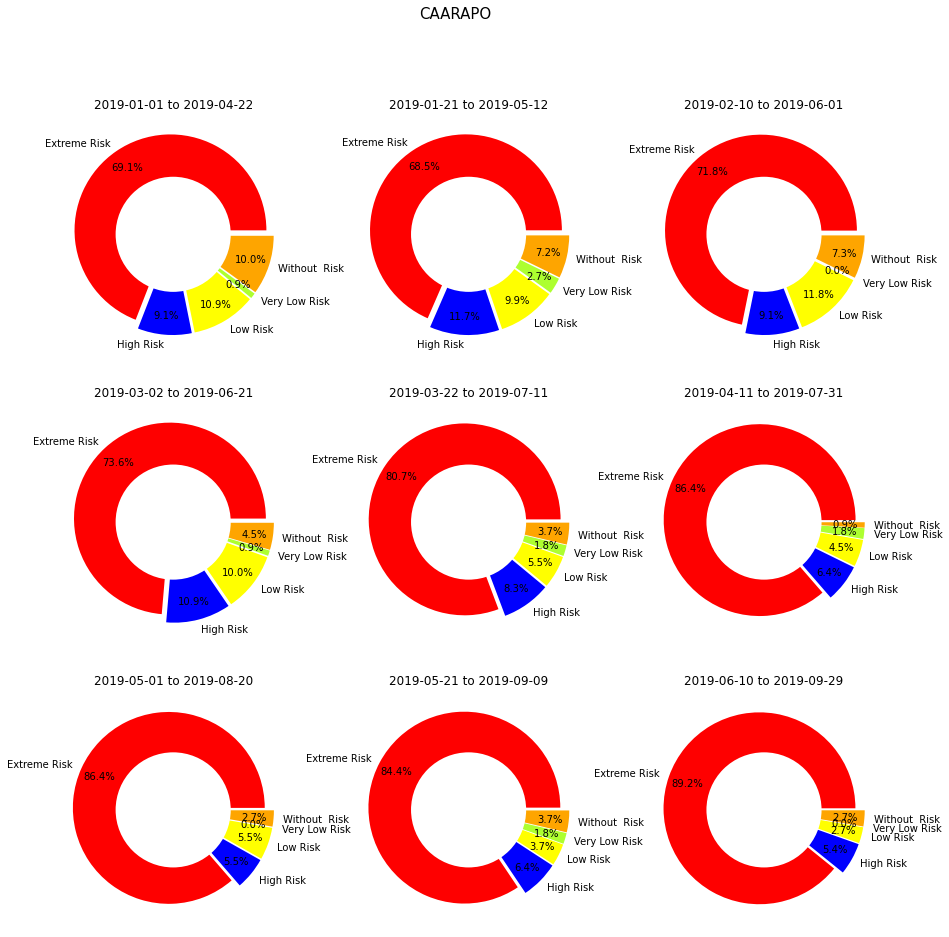

In [43]:
colors = ['#fe0000', '#0000fe', '#ffff00', '#adff30', '#fea500']
for j in range(1):
    fig, axs = plt.subplots(nrows=3, ncols=3)
    fig.set_size_inches(15, 15)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.pie(isnas[j].iloc[:,i][:-1], labels=isnas[j].index[:-1], autopct='%1.1f%%', pctdistance=0.8, explode=[.05]*5, colors = colors)
        cc = plt.Circle((0, 0), 0.6, fc='white')
        ax.add_artist(cc)
        ax.title.set_text(isnas[0].columns[i])
    periodo = isnas[j].name
    fig.suptitle(periodo, fontsize=15)
    fig.savefig(f'datasets/isnas/{periodo}.png')

In [44]:
isnas[0].index

Index(['Extreme Risk', 'High Risk', 'Low Risk', 'Very Low Risk',
       'Without  Risk', 'Erro'],
      dtype='object')

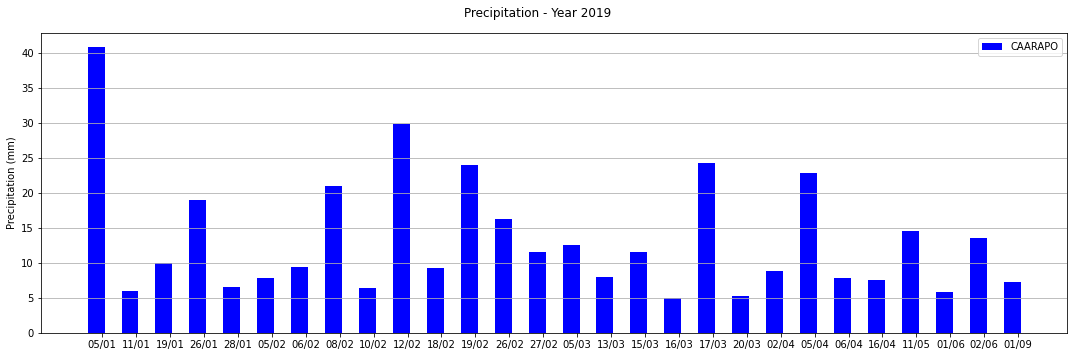

In [52]:
from bokeh.palettes import magma, Category20                  # paleta de cores
dfConsolidado = pd.read_csv("datasets/consolidado.csv",";");  

dfConsolidado = dfConsolidado[dfConsolidado['ESTADO'] =='MS']
dfConsolidado = dfConsolidado[(dfConsolidado['NOME'] == 'CAARAPO')] 
dfConsolidado = dfConsolidado[(dfConsolidado['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] >= 5)] 
dfConsolidado = dfConsolidado[(dfConsolidado['Data'] < '2019-10-01')] 
dfConsolidado['MES'] =  dfConsolidado['Data'].apply(lambda x: str(x)[5:7])
dfConsolidado['DIAMES'] =  dfConsolidado['Data'].apply(lambda x: str(x)[8:10])+'/'+dfConsolidado['Data'].apply(lambda x: str(x)[5:7])
 
nd = pd.DataFrame(dfConsolidado, columns=['NOME','DIAMES', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']).reset_index()

dfCAARAPO =   nd[nd['NOME'] =='CAARAPO']
tmp1 = dfCAARAPO['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

dfMES = dfCAARAPO['DIAMES'] 
 
# exemplo - grafico
x = dfMES
y1 = tmp1

# matplotlib-exemplo-40
# Histogramas de cores
barWidth = 0.18

labels  = x 
fig, ax = plt.subplots(figsize=(15, 5))
width = 0.50 # largura da barra

r1 = np.arange(len(y1))

ax.bar(r1, y1, width, color='blue', label='CAARAPO',align='center')

# labels, grids, titulos e gravar a figura
ax.set_xticks(ticks=[r + barWidth for r in range(len(y1))])
ax.set_xticklabels(labels)

ax.yaxis.grid(True)
ax.legend(loc='best')
ax.set_ylabel('Precipitation (mm)')
fig.suptitle('Precipitation - Year 2019')
fig.tight_layout(pad=1)
